In [1]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import gc
import warnings
import itertools
import multiprocessing
import time

import tensorflow as tf
import keras
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras import backend as K
from keras import regularizers
from collections import Counter
import lightgbm as lgb
from sklearn.ensemble import IsolationForest, RandomForestRegressor

from tsfresh.feature_extraction import extract_features
from astropy.cosmology import FlatLambdaCDM

warnings.filterwarnings("ignore")

Using TensorFlow backend.
/Users/jayzern/cs342/assignmentone-jayzern/venv/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Set cores to improve speed
cores=multiprocessing.cpu_count()

### Extracting Features from train set

In [3]:
gc.enable()

# Read files
meta_train = pd.read_csv('/modules/cs342/Assignment2/training_set_metadata.csv')
train = pd.read_csv('/modules/cs342/Assignment2/training_set.csv')

# Generate aggregate values of time series as usual
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq'] 
train['flux_magnitude'] = -2.5*np.log(train['flux'])

aggs = {
    'flux_magnitude': ['min', 'std', 'skew'],
    'mjd': ['size'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

agg_train.head()

gc.collect()

173

In [4]:
# EXTRA: find the passband of the max and min flux values
def featurizePassbandMaxFlux(df):
    idx = df.groupby('object_id')['flux'].transform(max) == df['flux']
    agg_df_ts_passband = df[idx].reset_index()[['object_id', 'passband']]
    agg_df_ts_passband.rename(columns={'passband': 'passband_max_flux'}, inplace=True)
    
    return agg_df_ts_passband

def featurizePassbandMinFlux(df):
    idx = df.groupby('object_id')['flux'].transform(min) == df['flux']
    agg_df_ts_passband = df[idx].reset_index()[['object_id', 'passband']]
    agg_df_ts_passband.rename(columns={'passband': 'passband_min_flux'}, inplace=True)
    
    return agg_df_ts_passband

# Merge them
agg_train_ts_passband = featurizePassbandMaxFlux(train)
agg_train = pd.merge(agg_train, agg_train_ts_passband, on='object_id')
agg_train_ts_passband = featurizePassbandMinFlux(train)
agg_train = pd.merge(agg_train, agg_train_ts_passband, on='object_id')

In [5]:
# Taken from https://www.kaggle.com/iprapas/ideas-from-kernels-and-discussion-lb-1-135?fbclid=IwAR29tt_a4NtF8_eYeFTGyKnsJlLWHgRcDDiRLXmaIl9sy3Tjw_VeeoUNj_0
def featurize(df):
    # METHOD I
    fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],
           'kurtosis' : None, 
           'skewness' : None}
    
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=cores)

    # METHOD III https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    df_det = df[df['detected']==1].copy()

    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None, 'mean_abs_change':None}, n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on = 'id')

    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id',inplace=True)
    
    return agg_df_ts

# Merge them together
agg_train_ts = featurize(train)
agg_train = pd.merge(agg_train, agg_train_ts, on='object_id')

Feature Extraction: 60it [00:08, 12.08it/s]                        
Feature Extraction: 20it [00:02,  9.87it/s]                        


In [6]:
# Featurize longest_strike for flux
def featurizeFlux(df):
    # Features to compute with tsfresh library
    fcp = {'longest_strike_above_mean': None, 'longest_strike_below_mean': None, 'mean_change': None, 'mean_abs_change':None}
    agg_df_ts_flux = extract_features(df, column_id='object_id', column_value='flux', default_fc_parameters=fcp, n_jobs=cores)
        
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts_flux.index.rename('object_id',inplace=True)
    
    return agg_df_ts_flux

# Featurize longest_strike for flux by flux
def featurizeFluxByFluxRatio(df):
    # Features to compute with tsfresh library
    fcp = {'longest_strike_above_mean': None, 'longest_strike_below_mean': None}
    agg_df_ts_flux_by_flux = extract_features(df, column_id='object_id', column_value='flux_by_flux_ratio_sq', default_fc_parameters=fcp, n_jobs=cores)
    
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts_flux_by_flux.index.rename('object_id',inplace=True)
    
    return agg_df_ts_flux_by_flux

# Merge them together
agg_train_ts_flux = featurizeFlux(train)
agg_train = pd.merge(agg_train, agg_train_ts_flux, on='object_id')
agg_train_ts_flux_by_flux = featurizeFluxByFluxRatio(train)
agg_train = pd.merge(agg_train, agg_train_ts_flux_by_flux, on='object_id')

Feature Extraction: 60it [00:01, 40.94it/s]                        
Feature Extraction: 60it [00:01, 46.17it/s]                        


### Merging extracted features with meta data

In [7]:
# METHOD II: abs magnitudes
def addAbsoluteMagnitudes(df):
    
    # Add: new distmod based on FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
    df['distmod_flatlambdacdm'] = cosmo.distmod(df['hostgal_photoz'])
    df['distmod_flatlambdacdm'] = df['distmod_flatlambdacdm'].replace(-np.inf, 0)

    # Add: absolute magnitudes
    df['flux_abs_magnitude_min'] = df['flux_magnitude_min'] - df['distmod_flatlambdacdm'].values
    df['flux_abs_magnitude_std'] = df['flux_magnitude_std'] - df['distmod_flatlambdacdm'].values
    df['flux_abs_magnitude_skew'] = df['flux_magnitude_skew'] - df['distmod_flatlambdacdm'].values
    df['flux_abs_magnitude_min'] = df['flux_abs_magnitude_min'].replace(np.nan, 100)
    df['flux_abs_magnitude_std'] = df['flux_abs_magnitude_std'].replace(np.nan, 100)
    df['flux_abs_magnitude_skew'] = df['flux_abs_magnitude_skew'].replace(np.nan, 100)
    
    return df

In [8]:
# EXTRA: Add special sauce feature for meta data!
meta_train['hostgal_photoz_certain'] = np.multiply(meta_train['hostgal_photoz'].values, np.exp(meta_train['hostgal_photoz_err'].values))
meta_train['milky_way'] = np.where(meta_train['hostgal_photoz']==0, 1, 0)


# Merge agg_train and meta train
full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

# Add absolute magnitudes
full_train = addAbsoluteMagnitudes(full_train)

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']

# EXTRA: Outlier detection using Isolation Forest to clean some values from class 15, 42, 90
# Basically removes outliers or noise to boost score slightly
unique_target = [15,42,90]
for target in unique_target:
    # Get rows of 1 target
    df_test = full_train[full_train['target']==target]
    
    # Fill mean
    df_mean = df_test.mean(axis=0)
    df_test.fillna(df_mean, inplace=True)
    
    # Find outliers
    outlier_detection = IsolationForest(contamination=0.05)
    outliers = outlier_detection.fit_predict(df_test)
    df_test['outlier'] = outliers
    
    # Remove them from full_train
    idx = df_test[df_test['outlier']==-1].index
    full_train = full_train.drop(idx, axis=0).reset_index()
    del full_train['level_0']


# Get y labels
if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
    del full_train['index']
    
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

('Unique classes : ', [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])


In [9]:
# Fill NaN with mean
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### OPTIONAL: Take 120,000 available hostgal_specz from test data to predict hostgal_specz

In [10]:
"""meta_test = pd.read_csv('../test_set_metadata.csv')
meta_test_hostgal_specz = meta_test[meta_test['hostgal_specz'].notna()]
meta_test_hostgal_specz_id = meta_test_hostgal_specz['object_id'].unique()

import time
start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../test_set.csv', chunksize=chunks, iterator=True)):
    df_ts_hostgal_specz = df[df['object_id'].isin(meta_test_hostgal_specz_id)]
    
    if i_c == 0:
        df_ts_hostgal_specz.to_csv('test_hostgal_specz.csv',  header=True, index=False)
    else: 
        df_ts_hostgal_specz.to_csv('test_hostgal_specz.csv',  header=False, mode='a', index=False)

    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))"""

"meta_test = pd.read_csv('../test_set_metadata.csv')\nmeta_test_hostgal_specz = meta_test[meta_test['hostgal_specz'].notna()]\nmeta_test_hostgal_specz_id = meta_test_hostgal_specz['object_id'].unique()\n\nimport time\nstart = time.time()\nchunks = 5000000\nfor i_c, df in enumerate(pd.read_csv('../test_set.csv', chunksize=chunks, iterator=True)):\n    df_ts_hostgal_specz = df[df['object_id'].isin(meta_test_hostgal_specz_id)]\n    \n    if i_c == 0:\n        df_ts_hostgal_specz.to_csv('test_hostgal_specz.csv',  header=True, index=False)\n    else: \n        df_ts_hostgal_specz.to_csv('test_hostgal_specz.csv',  header=False, mode='a', index=False)\n\n    if (i_c + 1) % 10 == 0:\n        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))"

In [11]:
"""test_hostgal_specz = pd.read_csv('./test_hostgal_specz.csv')

def processHostgalSpecz(df,meta_test):
    # Featurize Fourier Transform
    agg_test_ts = featurize(df)
    
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    df['flux_magnitude'] = -2.5*np.log(df['flux'])
    
    # Featurize passband
    agg_test_ts_passband_max = featurizePassbandMaxFlux(df)
    agg_test_ts_passband_min = featurizePassbandMinFlux(df)
    
    # Featurize Flux based on DFT and mjd_diff_det
    agg_test_ts_flux = featurizeFlux(df)
    
    # Featurize Flux By Flux
    agg_test_ts_flux_by_flux = featurizeFluxByFluxRatio(df)

    # Simple Aggregate
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    # Merge all tsfresh features
    agg_test = pd.merge(agg_test, agg_test_ts, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_passband_max, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_passband_min, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_flux, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_flux_by_flux, on='object_id')

    # Add: 'special sauce' feature for meta data
    meta_test['hostgal_photoz_certain'] = np.multiply(meta_test['hostgal_photoz'].values, np.exp(meta_test['hostgal_photoz_err'].values))
    meta_test['milky_way'] = np.where(meta_test['hostgal_photoz']==0, 1, 0)

    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    del full_test['index']
    
    # Add: Absolute Magnitudes
    full_test = addAbsoluteMagnitudes(full_test)
    
    # Get hostgal specz
    specz = full_test['hostgal_specz']
    
    # Get relevant columns
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    
    return full_test, specz

x_train, y_train = processHostgalSpecz(test_hostgal_specz, meta_test_hostgal_specz)
x_train.to_csv('test_hostgal_specz_x_train',  header=True, index=False)
y_train.to_csv('test_hostgal_specz_y_train.csv',  header=True, index=False)"""

"test_hostgal_specz = pd.read_csv('./test_hostgal_specz.csv')\n\ndef processHostgalSpecz(df,meta_test):\n    # Featurize Fourier Transform\n    agg_test_ts = featurize(df)\n    \n    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)\n    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']\n    df['flux_magnitude'] = -2.5*np.log(df['flux'])\n    \n    # Featurize passband\n    agg_test_ts_passband_max = featurizePassbandMaxFlux(df)\n    agg_test_ts_passband_min = featurizePassbandMinFlux(df)\n    \n    # Featurize Flux based on DFT and mjd_diff_det\n    agg_test_ts_flux = featurizeFlux(df)\n    \n    # Featurize Flux By Flux\n    agg_test_ts_flux_by_flux = featurizeFluxByFluxRatio(df)\n\n    # Simple Aggregate\n    agg_test = df.groupby('object_id').agg(aggs)\n    agg_test.columns = new_columns\n    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']\n    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean

In [12]:
"""x_train = pd.read_csv('test_hostgal_specz_x_train')
y_train = pd.read_csv('test_hostgal_specz_y_train.csv')

del x_train['object_id'], x_train['distmod'], x_train['hostgal_specz']
del x_train['ra'], x_train['decl'], x_train['gal_l'], x_train['gal_b'], x_train['ddf']"""

"x_train = pd.read_csv('test_hostgal_specz_x_train')\ny_train = pd.read_csv('test_hostgal_specz_y_train.csv')\n\ndel x_train['object_id'], x_train['distmod'], x_train['hostgal_specz']\ndel x_train['ra'], x_train['decl'], x_train['gal_l'], x_train['gal_b'], x_train['ddf']"

In [13]:
"""# Fit model and predict hostgal_specz
regr = RandomForestRegressor()
regr.fit(x_train, y_train)
preds = regr.predict(full_train)
full_train['hostgal_specz'] = preds"""

"# Fit model and predict hostgal_specz\nregr = RandomForestRegressor()\nregr.fit(x_train, y_train)\npreds = regr.predict(full_train)\nfull_train['hostgal_specz'] = preds"

### Standard Scaler

In [14]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

### Define Loss Function

In [15]:
def mywloss(ytrue,ypred): 
    yc = tf.clip_by_value(ypred,1e-15,1-1e-15) 
    loss = -(tf.reduce_mean(tf.reduce_mean(ytrue*tf.log(yc),axis=0)/wtable))
    return loss

def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

### Tune LGBM using forward/backward stepwise selection

In [16]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [17]:
y_count = Counter(y_map)
global wtable
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = float(y_count[i])/float(y_map.shape[0]) # OMG BUG HERE

In [18]:
print "Features used are:"
print full_train.columns
print full_train.shape

Features used are:
Index([u'mjd_size', u'flux_by_flux_ratio_sq_sum',
       u'flux_by_flux_ratio_sq_skew', u'flux_ratio_sq_sum',
       u'flux_ratio_sq_skew', u'flux_err_min', u'flux_err_max',
       u'flux_err_mean', u'flux_err_median', u'flux_err_std', u'flux_err_skew',
       u'flux_min', u'flux_max', u'flux_mean', u'flux_median', u'flux_std',
       u'flux_skew', u'detected_mean', u'flux_magnitude_min',
       u'flux_magnitude_std', u'flux_magnitude_skew', u'flux_diff',
       u'flux_dif2', u'flux_w_mean', u'flux_dif3', u'passband_max_flux',
       u'passband_min_flux', u'0__fft_coefficient__coeff_0__attr_"abs"',
       u'0__fft_coefficient__coeff_1__attr_"abs"', u'0__kurtosis',
       u'0__skewness', u'1__fft_coefficient__coeff_0__attr_"abs"',
       u'1__fft_coefficient__coeff_1__attr_"abs"', u'1__kurtosis',
       u'1__skewness', u'2__fft_coefficient__coeff_0__attr_"abs"',
       u'2__fft_coefficient__coeff_1__attr_"abs"', u'2__kurtosis',
       u'2__skewness', u'3__fft_coeffici

In [19]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'min_data_per_group': 100,
    'metric': 'multi_logloss',
    'learning_rate': 0.031,
    'drop_rate': 0.18,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_child_samples': 10,
    'min_split_gain': 0.1,
    'min_child_weight': 100,
    'n_estimators': 500, #500 # 1000 was original
    'n_jobs': -1,
    'silent': -1,
    'verbose': -1,
    'max_depth': 3
}

# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train_ss), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    # Get train and test
    trn_x, trn_y = full_train_ss[trn_], y[trn_]
    val_x, val_y = full_train_ss[val_], y[val_]
    
    # Train LGBM
    clf = lgb.LGBMClassifier(**lgb_params)
    print clf
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))
    
    # Get the gain entropy
    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        drop_rate=0.18, importance_type='split', learning_rate=0.031,
        max_depth=3, metric='multi_logloss', min_child_samples=10,
        min_child_weight=100, min_data_per_group=100, min_split_gain=0.1,
        n_estimators=500, n_jobs=-1, num_class=14, num_leaves=31,
        objective='multiclass', random_state=None, reg_alpha=0.01,
        reg_lambda=0.01, silent=-1, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1)
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 1.00634	valid_0's wloss: 0.717049	valid_1's multi_logloss: 1.08039	valid_1's wloss: 0.908553
[200]	valid_0's multi_logloss: 0.750551	valid_0's wloss: 0.48206	valid_1's multi_logloss: 0.867166	valid_1's wloss: 0.730914
[300]	valid_0's multi_logloss: 0.635727	valid_0's wloss: 0.38541	valid_1's multi_logloss: 0.79184	valid_1's wloss: 0.688946
[400]	valid_0's multi_loglos

Normalized confusion matrix
[[9.27e-01 0.00e+00 6.62e-03 0.00e+00 0.00e+00 6.62e-03 0.00e+00 0.00e+00
  5.96e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 7.68e-01 0.00e+00 5.74e-02 1.91e-02 0.00e+00 2.98e-02 6.38e-03
  0.00e+00 3.62e-02 0.00e+00 7.87e-02 0.00e+00 4.26e-03]
 [2.16e-03 0.00e+00 9.86e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  3.25e-03 0.00e+00 0.00e+00 0.00e+00 8.66e-03 0.00e+00]
 [0.00e+00 9.53e-02 0.00e+00 4.53e-01 7.24e-02 0.00e+00 1.58e-01 1.06e-02
  0.00e+00 5.56e-02 0.00e+00 1.37e-01 0.00e+00 1.85e-02]
 [0.00e+00 3.28e-02 0.00e+00 1.48e-01 3.28e-01 0.00e+00 1.09e-01 0.00e+00
  0.00e+00 7.10e-02 0.00e+00 3.06e-01 0.00e+00 5.46e-03]
 [6.67e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.33e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 8.26e-03 0.00e+00 1.43e-01 5.37e-02 0.00e+00 5.62e-01 2.69e-02
  0.00e+00 1.24e-01 0.00e+00 7.44e-02 0.00e+00 8.26e-03]
 [0.00e+00 9.80e-03 0.00e+00 1.96e-02 9.80e-03 0.00e+00

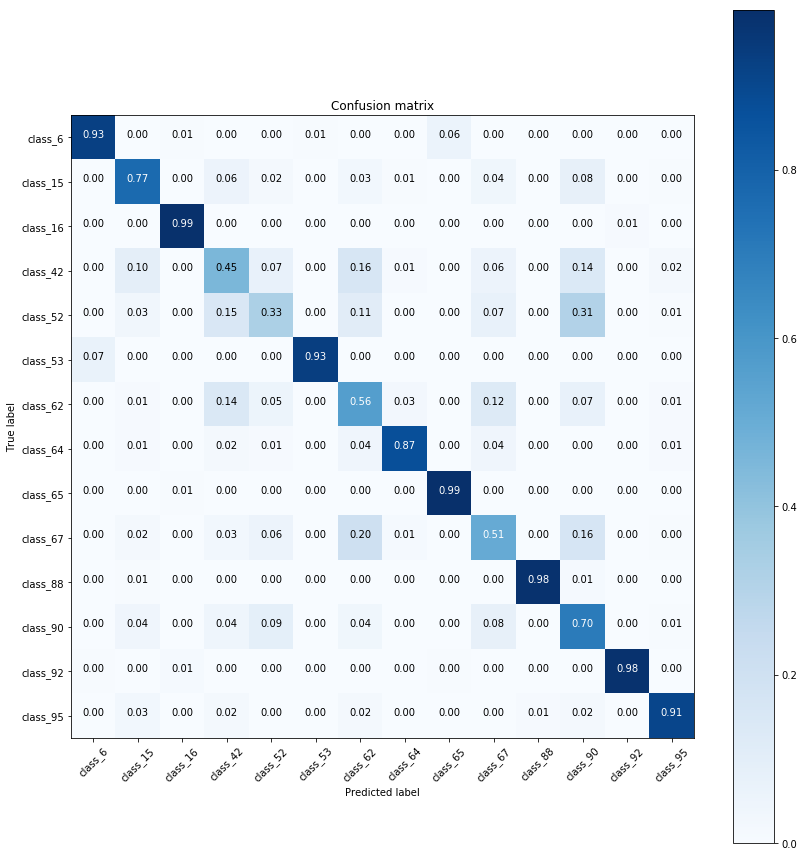

In [20]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv('/modules/cs342/Assignment2/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

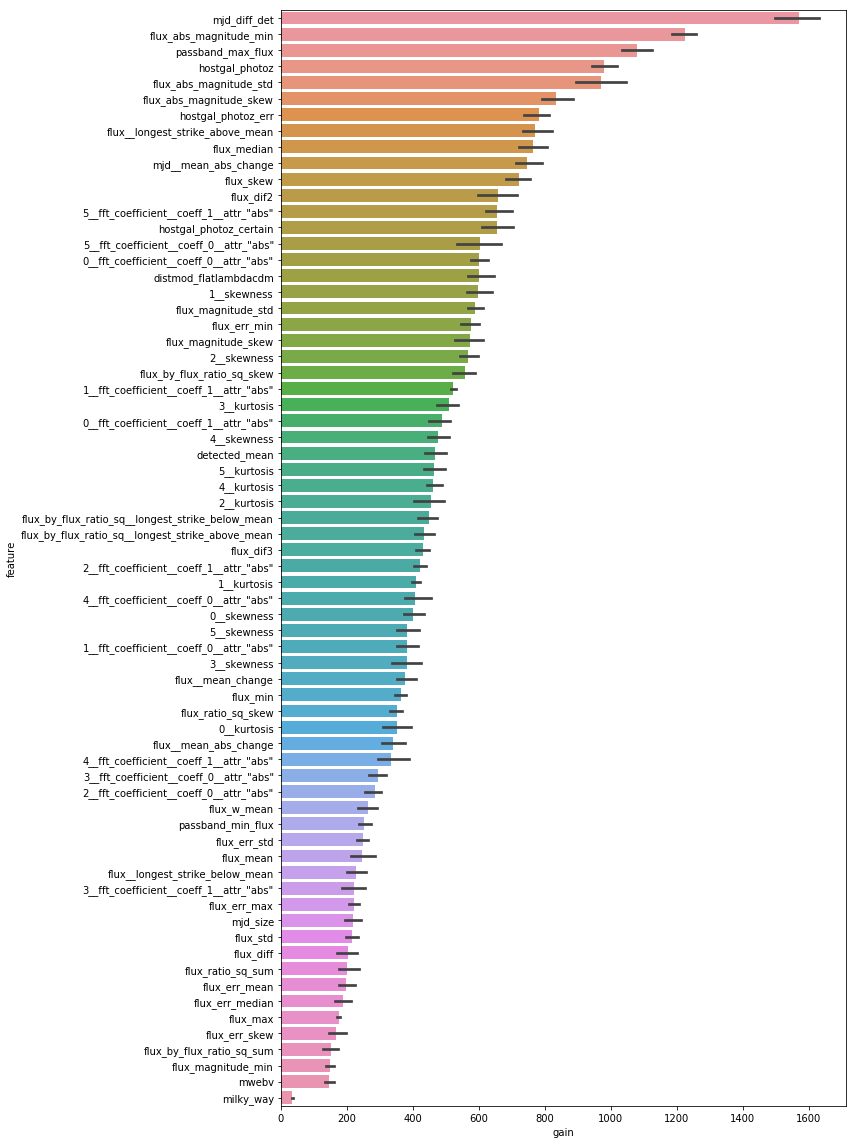

In [21]:
# Plot feature importance
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(12, 16))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances.png')
    
save_importances(importances_=importances)

### Test Set Predictions

In [ ]:
"""meta_test = pd.read_csv('../test_set_metadata.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../test_set.csv', chunksize=chunks, iterator=True)):
    # Featurize Fourier Transform
    agg_test_ts = featurize(df)
    
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    df['flux_magnitude'] = -2.5*np.log(df['flux'])
    
    # Featurize passband
    agg_test_ts_passband_max = featurizePassbandMaxFlux(df)
    agg_test_ts_passband_min = featurizePassbandMinFlux(df)
    
    # Featurize Flux based on DFT and mjd_diff_det
    agg_test_ts_flux = featurizeFlux(df)
    
    # Featurize Flux By Flux
    agg_test_ts_flux_by_flux = featurizeFluxByFluxRatio(df)

    # Simple Aggregate
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']


    # Merge all tsfresh features
    agg_test = pd.merge(agg_test, agg_test_ts, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_passband_max, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_passband_min, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_flux, on='object_id')
    agg_test = pd.merge(agg_test, agg_test_ts_flux_by_flux, on='object_id')

    # Add: 'special sauce' feature for meta data
    meta_test['hostgal_photoz_certain'] = np.multiply(meta_test['hostgal_photoz'].values, np.exp(meta_test['hostgal_photoz_err'].values))
    meta_test['milky_way'] = np.where(meta_test['hostgal_photoz']==0, 1, 0)

    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    del full_test['index']
    
    # Add: Absolute Magnitudes
    full_test = addAbsoluteMagnitudes(full_test)
    
    # Get relevant columns
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    
    # OPTIONAL: Predict Specz
    # preds = regr.predict(full_test[full_train.columns].drop('hostgal_specz',axis=1))
    # full_test['hostgal_specz'] = preds
    
    full_test_ss = ss.transform(full_test[full_train.columns])
    
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.19 * preds_99 / np.mean(preds_99) # og: 0.14, 0.18
    
    if i_c == 0:
        preds_df.to_csv('predictions2.csv',  header=True, index=False)
    else: 
        preds_df.to_csv('predictions2.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds

    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
        
z = pd.read_csv('predictions2.csv')
print z.dtypes

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions2.csv', index=True)"""